# 0️⃣ Prerequisite

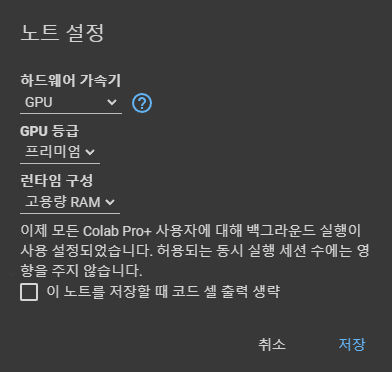

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 20.6 MB/s 
     |████████████████████████████████| 182 kB 97.8 MB/s 
     |████████████████████████████████| 7.6 MB 81.1 MB/s 


## ✅ Intall wnadb library and login

In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 28.7 MB/s 
     |████████████████████████████████| 182 kB 91.7 MB/s 
     |████████████████████████████████| 174 kB 87.9 MB/s 
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 173 kB 88.1 MB/s 
     |████████████████████████████████| 168 kB 105.2 MB/s 
     |████████████████████████████████| 168 kB 105.3 MB/s 
     |████████████████████████████████| 166 kB 81.5 MB/s 
     |████████████████████████████████| 166 kB 101.8 MB/s 
     |████████████████████████████████| 162 kB 102.8 MB/s 
     |████████████████████████████████| 162 kB 101.3 MB/s 
     |████████████████████████████████| 158 kB 99.7 MB/s 
     |████████████████████████████████| 157 kB 104.7 MB/s 
     |████████████████████████████████| 157 kB 104.2 MB/s 
     |████████████████████████████████| 157 kB 101.5 MB/s 
     |███████████████████

In [3]:
# Log in to your W&B account
import wandb
wandb.login()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
import os
import pdb
import argparse
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict
import random

import torch
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim

import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

# 📈 For Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Preprocess

In [5]:
def make_id_file(task, tokenizer):
    def make_data_strings(file_name):
        data_strings = []
        with open(os.path.join(file_name), 'r', encoding='utf-8') as f:
            id_file_data = [tokenizer.encode(line.lower()) for line in f.readlines()]
        for item in id_file_data:
            data_strings.append(' '.join([str(k) for k in item]))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1')
    train_neg = make_data_strings('sentiment.train.0')
    dev_pos = make_data_strings('sentiment.dev.1')
    dev_neg = make_data_strings('sentiment.dev.0')

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

## ✅ Tokenizer

- 원하는 tokenizer로 수정
```
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
```
- [BERT](https://huggingface.co/docs/transformers/model_doc/bert#transformers.TFBertTokenizer)

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
from google.colab import files
uploaded = files.upload()

Saving sentiment.dev.0 to sentiment.dev.0
Saving sentiment.dev.1 to sentiment.dev.1
Saving sentiment.train.0 to sentiment.train.0
Saving sentiment.train.1 to sentiment.train.1
Saving test_no_label.csv to test_no_label.csv


In [24]:
!ls

1234.png     sentiment.dev.0  sentiment.train.0  test_no_label.csv
sample_data  sentiment.dev.1  sentiment.train.1


In [25]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file('yelp', tokenizer)

it will take some times...
make id file finished!


## Visualization

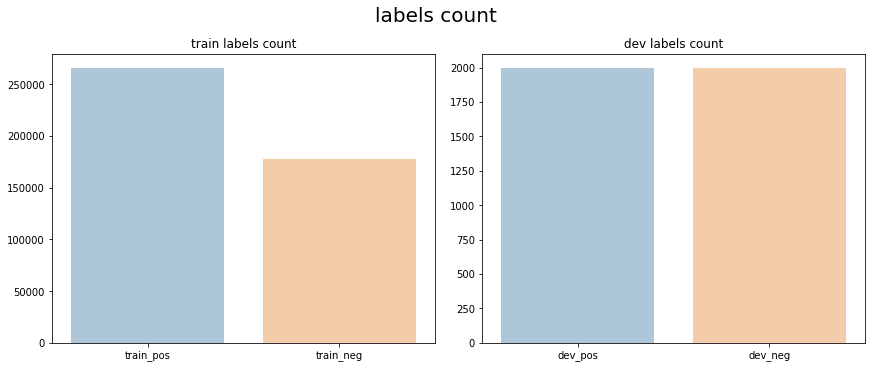

In [27]:
fig, ax = plt.subplots(ncols = 2, figsize = (12, 5), constrained_layout = True)

g1 = sns.barplot(x = np.array(['train_pos', 'train_neg']),
                y = np.array([len(train_pos), len(train_neg)]),
                alpha = .4, ax = ax[0])
g1.set_title("train labels count")

g2 = sns.barplot(x = np.array(['dev_pos', 'dev_neg']),
                y = np.array([len(dev_pos), len(dev_neg)]),
                alpha = .4, ax = ax[1])
g2.set_title("dev labels count")

fig.suptitle('labels count', fontsize=20)
plt.show()

In [28]:
train_pos[:10]

['101 6581 2833 1012 102',
 '101 21688 8013 2326 1012 102',
 '101 2027 2036 2031 3679 19247 1998 3256 6949 2029 2003 2428 2204 1012 102',
 '101 2009 1005 1055 1037 2204 15174 2098 7570 22974 2063 1012 102',
 '101 1996 3095 2003 5379 1012 102',
 '101 2204 3347 2833 1012 102',
 '101 2204 2326 1012 102',
 '101 11350 1997 2154 2003 25628 1998 7167 1997 19247 1012 102',
 '101 2307 2173 2005 6265 2030 3347 27962 1998 5404 1012 102',
 '101 1996 2047 2846 3504 6429 1012 102']

In [29]:
class SentimentDataset(object):
    def __init__(self, tokenizer, pos, neg):
        self.tokenizer = tokenizer
        self.data = []
        self.label = []

        for pos_sent in pos:
            self.data += [self._cast_to_int(pos_sent.strip().split())]
            self.label += [[1]]
        for neg_sent in neg:
            self.data += [self._cast_to_int(neg_sent.strip().split())]
            self.label += [[0]]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample), np.array(self.label[index])

In [30]:
train_dataset = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset = SentimentDataset(tokenizer, dev_pos, dev_neg)

## ✅ Small sample of dataset

- 데이터셋 20%만 사용하고 싶다면 주석 해제

In [62]:
train_dataset_total = SentimentDataset(tokenizer, train_pos, train_neg)
dev_dataset_total = SentimentDataset(tokenizer, dev_pos, dev_neg)

train_dataset = random.sample(list(train_dataset_total), int(0.01 * len(train_dataset_total)))
dev_dataset = random.sample(list(dev_dataset_total), int(0.01 * len(dev_dataset_total)))

print(len(train_dataset_total))
print(len(dev_dataset_total))
print(len(train_dataset))
print(len(dev_dataset))

443259
4000
4432
40


In [63]:
# train dataset 10개 인쇄
for i, item in enumerate(train_dataset):
    print(item)
    if i == 10:
        break

(array([  101,  2129,  2027, 13017,  2008, 26476,  2000,  2022,  3929,
       12984,  2003,  1037,  6547,  1012,   102]), array([0]))
(array([  101,  3243, 19597,  1010,  2057,  2097,  2196,  2175,  2067,
        2000,  2023,  4825,  1012,   102]), array([0]))
(array([  101,  2938,  2006,  1996,  2235,  2392, 19404,  2006,  1037,
        3835, 11559,  2851,  1012,   102]), array([1]))
(array([  101, 14044,  1998,  2081,  1996,  8810,  1037,  2204,  2946,
        1012,   102]), array([1]))
(array([  101,  2023,  2173,  2003,  2074,  2054,  2017,  2215,  1999,
        2019, 10569,  3962,  1012,   102]), array([1]))
(array([  101,  2026,  5440,  2024,  1996,  6861, 19724,  1997,  2607,
        1012,   102]), array([1]))
(array([ 101, 2833, 1998, 8974, 1011, 1011, 2204, 1012,  102]), array([1]))
(array([  101,  1035, 16371,  2213,  1035,  1012,   102]), array([0]))
(array([  101,  1045,  2052,  5791, 16755,  2009,   999,   102]), array([1]))
(array([ 101, 3071, 2003, 3565, 5379, 1012,  102

In [64]:
def collate_fn_style(samples):
    input_ids, labels = zip(*samples)
    max_len = max(len(input_id) for input_id in input_ids)
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]

    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])
    labels = torch.tensor(np.stack(labels, axis=0)[sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids, labels

# 2️⃣ Model: Training & Validation

In [65]:
# random seed
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [66]:
def compute_acc(predictions, target_labels):
    return (np.array(predictions) == np.array(target_labels)).mean()

## Hyperparameter Tuning using WandB 🐝

In [67]:
def build_optimizer(model, optimizer, learning_rate, weight_decay):
    if optimizer == "adam":
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer == 'adamw':
        optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    return optimizer

### ✅ Define sweep config

- [`method`](https://docs.wandb.ai/guides/sweeps/define-sweep-configuration#method)
```
'method': 'grid',
```
    - grid: Grid search iterates over all possible combinations of parameter values.
    - random: Random search chooses a random set of values on each iteration.
    - bayes: Our Bayesian hyperparameter search method uses a Gaussian Process to model the relationship between the parameters and the model metric and chooses parameters to optimize the probability of improvement. This strategy requires the metric key to be specified.
---
- Learning Rate =====> 5e-05 (baseline), 1e-05, 1e-04
- Batch Size =====> (32, 64) (baseline), (64, 128)
- Optimization =====> [AdamW](https://huggingface.co/docs/transformers/main_classes/optimizer_schedules#transformers.AdamW)
- Weight Decay =====> 0 (baseline), 0.1
- Epochs =====> 3 (baseline), 2 

In [68]:
# 🐝 Step 1: Define sweep config
sweep_configuration = {
    'method': 'grid', # 'random'
    'name': 'sweep',
    'metric': {'goal': 'maximize', 'name': 'val_acc'},
    'parameters':
    {
        'batch_size': {'values': [32, 64]},
        'optimizer': {'values': ['adamw']},
        'lr': {'values': [5e-05, 1e-05, 1e-04]}, # {'max': 0.1, 'min': 0.0001}
        'weight_decay': {'values': [0, 0.1]}, # {'max': 0.1, 'min': 0.0}
        'epochs': {'values': [2]} # {'values': [1]}
    }
}

# 🐝 Step 2: Initialize sweep by passing in config
sweep_id = wandb.sweep(sweep=sweep_configuration, project='my-first-sweep')

Create sweep with ID: nxivuae6
Sweep URL: https://wandb.ai/yangdk02/my-first-sweep/sweeps/nxivuae6


### ✅ Define Pretraind Language Model

- 원하는 모델로 수정
```
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
```
- lowest_val_acc보다 크면 parameters 저장 → Train & Submit 단계에서 바로 사용할 수 있도록
```
lowest_val_acc = 0.9
(중략)
                    if val_acc > lowest_val_acc:
                        torch.save(model.state_dict(), my_name)
```

In [69]:
lowest_val_acc = 0.9

# 🐝 Step 3: Define training function that takes in hyperparameter 
# values from `wandb.config` and uses them to train a model and return metric
def main():
    # 🐝 initialise a wandb run
    # Use the wandb.init() API to generate a background process 
    # to sync and log data as a Weights and Biases run.
    # Optionally provide the name of the project.
    # 🐝 initialise a wandb run
    run = wandb.init(project='my-first-sweep')

    # note that we define values from `wandb.config` instead of 
    # defining hard values
    batch_size = wandb.config.batch_size
    optim = wandb.config.optimizer
    lr  =  wandb.config.lr
    weight_decay = wandb.config.weight_decay
    epochs = wandb.config.epochs

    my_name = "model_" + str(batch_size) + "_" + str(optim) + "_" + str(lr) + "_" + str(weight_decay) + "_" + str(epochs)
    run.name = my_name

    # Get the data
    train_loader = torch.utils.data.DataLoader( # Train dataset
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn_style,
        pin_memory=True, num_workers=2)
    dev_loader = torch.utils.data.DataLoader( # Validation dataset
        dev_dataset,
        batch_size=batch_size*2,
        shuffle=False,
        collate_fn=collate_fn_style,
        num_workers=2)
    
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
    model.to(device)

    # Make the loss and optimizer
    optimizer = build_optimizer(model, optim, lr, weight_decay)

     # 📈 For visualization using Matplotlib
    train_loss_history = []
    valid_loss_history = []

    # Training
    for epoch in range(epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            for iteration, (input_ids, attention_mask, token_type_ids, position_ids, labels) in enumerate(tepoch):
                model.train()
                tepoch.set_description(f"Epoch {epoch}")
                
                # Train
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                token_type_ids = token_type_ids.to(device)
                position_ids = position_ids.to(device)
                labels = labels.to(device, dtype=torch.long)

                optimizer.zero_grad()
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    position_ids=position_ids,
                    labels=labels)
                train_loss = outputs.loss
                train_loss.backward()
                optimizer.step()
                
                # 🐝 Log train metrics to wandb 
                wandb.log({
                    "train_loss": train_loss,
                    "epoch": epoch
                })

                tepoch.set_postfix(loss=train_loss.item())

                if iteration != 0 and iteration % int(len(train_loader) / 5) == 0:
                    # Evaluate the model five times per epoch
                    model.eval()
                    with torch.no_grad():
                        val_losses = []
                        predictions = []
                        target_labels = []
                        for input_ids, attention_mask, token_type_ids, position_ids, labels in tqdm(
                            dev_loader,
                            desc='Eval',
                            position=1,
                            leave=None):
                            # Validation
                            input_ids = input_ids.to(device)
                            attention_mask = attention_mask.to(device)
                            token_type_ids = token_type_ids.to(device)
                            position_ids = position_ids.to(device)
                            labels = labels.to(device, dtype=torch.long)

                            outputs = model(
                                input_ids=input_ids,
                                attention_mask=attention_mask,
                                token_type_ids=token_type_ids,
                                position_ids=position_ids,
                                labels=labels)
                            loss = outputs.loss
                            logits = outputs.logits
                            val_losses.append(loss.item())

                            batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
                            batch_labels = [int(example) for example in labels]

                            predictions += batch_predictions
                            target_labels += batch_labels
                    
                    val_loss = sum(val_losses) / len(val_losses)
                    val_acc = compute_acc(predictions, target_labels)

                    # 🐝 Log validation metrics to wandb
                    wandb.log({
                        "val_loss": val_loss,
                        "val_acc": val_acc
                    })
                    train_loss_history.append(train_loss)  # 📈 For visualization using Matplotlib
                    valid_loss_history.append(val_loss)  # 📈 For visualization using Matplotlib
                    print('=====> val_acc: ', val_acc)
                    
                    # 💾 lowest_val_acc보다 크면 parameters 저장 → Train & Submit 단계에서 바로 사용할 수 있도록
                    if val_acc > lowest_val_acc:
                        torch.save(model.state_dict(), my_name + '_ckp.bin') # checkpoint
                        print('\nSaved the model!')

    # 💾 학습이 완료되면 최종 parameters를 저장
    torch.save(model.state_dict(), my_name + '.bin')

    # 📈 For visualization using Matplotlib
    # 간단하게 train loss & validation loss 시각화
    train_loss_history = torch.tensor(train_loss_history).detach().cpu().numpy()
    valid_loss_history = torch.tensor(valid_loss_history).detach().cpu().numpy()
    plt.plot(train_loss_history, label = "Train Loss")
    plt.plot(valid_loss_history, label = "Validation Loss")
    plt.title('Loss (' + my_name + ')')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(my_name + '.png') # 💾
    plt.close()

- [`wnadb.agent`](https://docs.wandb.ai/ref/python/agent)
    - count
(int, optional) the number of trials to run.

In [70]:
# 🐝 Step 4: Call to `wandb.agent` to start a sweep
wandb.agent(sweep_id, function=main)

wandb: Agent Starting Run: q7xxrsa3 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 2
wandb: 	lr: 5e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.925


Epoch 0:  22%|██▏       | 31/139 [00:03<00:19,  5.68batch/s, loss=0.171]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  41%|████      | 57/139 [00:06<00:19,  4.28batch/s, loss=0.267]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
                                                   

=====> val_acc:  0.95


Epoch 0:  61%|██████    | 85/139 [00:08<00:09,  5.87batch/s, loss=0.0736]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  80%|███████▉  | 111/139 [00:12<00:07,  3.97batch/s, loss=0.0517]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.07it/s]
                                                   

=====> val_acc:  0.925


Epoch 0: 100%|██████████| 139/139 [00:15<00:00,  5.54batch/s, loss=0.154]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.95it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  22%|██▏       | 31/139 [00:03<00:20,  5.31batch/s, loss=0.00647]


Saved the model!


Epoch 1:  41%|████      | 57/139 [00:05<00:06, 11.93batch/s, loss=0.0284]

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  61%|██████    | 85/139 [00:07<00:09,  5.88batch/s, loss=0.0605]


Saved the model!


Epoch 1:  80%|███████▉  | 111/139 [00:09<00:02, 11.87batch/s, loss=0.0137]

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
                                                   

=====> val_acc:  0.975


Epoch 1: 100%|██████████| 139/139 [00:12<00:00,  5.89batch/s, loss=0.0266]


Saved the model!


Epoch 1: 100%|██████████| 139/139 [00:12<00:00, 11.47batch/s, loss=0.0266]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,█▇▄▃▅▃▂▄▄▃▂▂▂▄▃▂▁▂▁▂▁▁▁▁▁▁▁▁▂▁▂▂▂▁▁▂▂▂▁▁
val_acc,▃▃▆▃▃▃▁▃▁█
val_loss,▅▅▁▆▆▆▆▆█▃
epoch,1
train_loss,0.02665
val_acc,0.975
val_loss,0.21263


wandb: Agent Starting Run: p33zgvd4 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 2
wandb: 	lr: 5e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  41%|████      | 57/139 [00:05<00:15,  5.23batch/s, loss=0.33]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.77it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  61%|██████    | 85/139 [00:07<00:09,  5.78batch/s, loss=0.0518]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.44it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  80%|███████▉  | 111/139 [00:10<00:05,  5.52batch/s, loss=0.15]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
                                                   

=====> val_acc:  0.925


Epoch 0: 100%|██████████| 139/139 [00:13<00:00,  6.22batch/s, loss=0.109]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  22%|██▏       | 31/139 [00:03<00:20,  5.16batch/s, loss=0.0472]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  41%|████      | 57/139 [00:05<00:14,  5.75batch/s, loss=0.0289]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.63it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  61%|██████    | 85/139 [00:08<00:09,  5.74batch/s, loss=0.0089]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  80%|███████▉  | 111/139 [00:11<00:04,  5.97batch/s, loss=0.0251]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.70it/s]
                                                   

=====> val_acc:  0.925


Epoch 1: 100%|██████████| 139/139 [00:14<00:00,  5.05batch/s, loss=0.00304]


Saved the model!


Epoch 1: 100%|██████████| 139/139 [00:14<00:00,  9.70batch/s, loss=0.00304]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,██▅▂▃▂▃▃▃▃▂▂▂▃▃▂▃▂▄▂▃▁▁▂▂▁▂▁▂▁▂▂▁▂▃▂▁▁▁▂
val_acc,▁█████████
val_loss,▃▂▂▁▃█▄▄▆▂
epoch,1
train_loss,0.00304
val_acc,0.925
val_loss,0.24683


wandb: Agent Starting Run: y9qh2m4b with config:
wandb: 	batch_size: 32
wandb: 	epochs: 2
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.825


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 12.16batch/s, loss=0.307]

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  61%|██████    | 85/139 [00:06<00:08,  6.47batch/s, loss=0.28]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.28it/s]
                                                   

=====> val_acc:  0.95


Epoch 0:  80%|███████▉  | 111/139 [00:09<00:04,  5.67batch/s, loss=0.0651]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.67it/s]
                                                   

=====> val_acc:  0.95


Epoch 0: 100%|██████████| 139/139 [00:11<00:00,  5.84batch/s, loss=0.339]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  22%|██▏       | 31/139 [00:03<00:20,  5.32batch/s, loss=0.035]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.25it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  41%|████      | 57/139 [00:05<00:14,  5.73batch/s, loss=0.12]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.23it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  61%|██████    | 85/139 [00:08<00:09,  5.60batch/s, loss=0.233]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  80%|███████▉  | 111/139 [00:11<00:04,  6.39batch/s, loss=0.194]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
                                                   

=====> val_acc:  0.925


Epoch 1: 100%|██████████| 139/139 [00:13<00:00,  5.75batch/s, loss=0.15]


Saved the model!


Epoch 1: 100%|██████████| 139/139 [00:13<00:00, 10.03batch/s, loss=0.15]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,▇█▇▇▆▆▄▄▃▃▂▂▂▂▃▂▁▃▂▁▁▂▂▂▂▂▁▁▃▃▂▂▃▂▂▁▁▁▂▁
val_acc,▁▅▇█████▇▇
val_loss,█▄▂▂▂▁▁▂▂▃
epoch,1
train_loss,0.15037
val_acc,0.925
val_loss,0.26573


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1dq5zm1d with config:
wandb: 	batch_size: 32
wandb: 	epochs: 2
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.775


Epoch 0:  41%|████      | 57/139 [00:04<00:07, 11.65batch/s, loss=0.253]

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  61%|██████    | 85/139 [00:06<00:10,  5.31batch/s, loss=0.128]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  80%|███████▉  | 111/139 [00:10<00:07,  3.60batch/s, loss=0.167]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.60it/s]
                                                   

=====> val_acc:  0.95


Epoch 0: 100%|██████████| 139/139 [00:13<00:00,  5.60batch/s, loss=0.286]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.46it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  22%|██▏       | 31/139 [00:03<00:20,  5.32batch/s, loss=0.0358]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  41%|████      | 57/139 [00:05<00:14,  5.77batch/s, loss=0.0482]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.11it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  61%|██████    | 85/139 [00:08<00:09,  5.78batch/s, loss=0.173]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.58it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  80%|███████▉  | 111/139 [00:11<00:04,  6.15batch/s, loss=0.128]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.75it/s]
                                                   

=====> val_acc:  0.95


Epoch 1: 100%|██████████| 139/139 [00:13<00:00,  5.73batch/s, loss=0.278]


Saved the model!


Epoch 1: 100%|██████████| 139/139 [00:13<00:00, 10.03batch/s, loss=0.278]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,▇█▇▆▆▄▄▃▃▄▆▂▂▂▃▄▂▂▃▃▁▂▃▁▃▂▂▁▁▁▂▁▂▃▂▁▃▁▁▁
val_acc,▁▆▇▇██████
val_loss,█▃▂▂▁▁▁▁▁▁
epoch,1
train_loss,0.27785
val_acc,0.95
val_loss,0.2104


wandb: Agent Starting Run: bp5mqgf5 with config:
wandb: 	batch_size: 32
wandb: 	epochs: 2
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.875


Epoch 0:  41%|████      | 57/139 [00:03<00:06, 12.22batch/s, loss=0.0476]

=====> val_acc:  0.875


Epoch 0:  61%|██████    | 85/139 [00:05<00:04, 12.44batch/s, loss=0.251]

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.56it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  80%|███████▉  | 111/139 [00:08<00:05,  5.42batch/s, loss=0.084]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]
                                                   

=====> val_acc:  0.925


Epoch 0: 100%|██████████| 139/139 [00:11<00:00,  5.67batch/s, loss=0.302]


Saved the model!


Epoch 1:  22%|██▏       | 31/139 [00:02<00:09, 11.91batch/s, loss=0.0333]

=====> val_acc:  0.9


Epoch 1:  41%|████      | 57/139 [00:03<00:06, 11.99batch/s, loss=0.169]

=====> val_acc:  0.9


Epoch 1:  61%|██████    | 85/139 [00:05<00:04, 12.34batch/s, loss=0.0972]

=====> val_acc:  0.875


Epoch 1:  80%|███████▉  | 111/139 [00:07<00:02, 12.29batch/s, loss=0.0386]

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.83it/s]
                                                   

=====> val_acc:  0.925


Epoch 1: 100%|██████████| 139/139 [00:10<00:00,  5.68batch/s, loss=0.0611]


Saved the model!


Epoch 1: 100%|██████████| 139/139 [00:10<00:00, 13.53batch/s, loss=0.0611]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,█▆▂▃▃▂▇▃▄▂▅▂▃▃▂▂▂▂▁▆▂▂▂▁▁▂▂▂▂▁▃▁▂▂▂▃▁▁▃▃
val_acc,▁▁▄██▄▄▁▄█
val_loss,▃▃▄▄▁▄▂▄█▂
epoch,1
train_loss,0.06114
val_acc,0.925
val_loss,0.22908


wandb: Agent Starting Run: 8xo9j1yv with config:
wandb: 	batch_size: 32
wandb: 	epochs: 2
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.925


Epoch 0:  22%|██▏       | 31/139 [00:02<00:16,  6.46batch/s, loss=0.207]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.64it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  41%|████      | 57/139 [00:05<00:14,  5.54batch/s, loss=0.233]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  61%|██████    | 85/139 [00:08<00:09,  5.71batch/s, loss=0.0253]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.73it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  80%|███████▉  | 111/139 [00:11<00:05,  5.55batch/s, loss=0.153]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]
                                                   

=====> val_acc:  0.925


Epoch 0: 100%|██████████| 139/139 [00:13<00:00,  5.55batch/s, loss=0.072]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]
                                                   

=====> val_acc:  0.975


Epoch 1:  22%|██▏       | 31/139 [00:03<00:20,  5.31batch/s, loss=0.0293]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  41%|████      | 57/139 [00:05<00:14,  5.48batch/s, loss=0.137]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.20it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  61%|██████    | 85/139 [00:09<00:15,  3.45batch/s, loss=0.0985]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.54it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  80%|███████▉  | 111/139 [00:12<00:05,  5.43batch/s, loss=0.0208]


Saved the model!


Epoch 1: 100%|██████████| 139/139 [00:14<00:00, 11.18batch/s, loss=0.115]

=====> val_acc:  0.9


Epoch 1: 100%|██████████| 139/139 [00:14<00:00,  9.38batch/s, loss=0.115]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,█▇▅▂▄▄▂▄▃▂▁▂▁▃▃▂▂▁▂▄▁▂▁▁▂▂▃▁▂▁▂▂▂▁▁▁▃▃▁▂
val_acc,▃▃▃▃▃█▃▃▃▁
val_loss,▃▅▅▁▄▆▇▆██
epoch,1
train_loss,0.11488
val_acc,0.9
val_loss,0.25511


wandb: Agent Starting Run: bt5x7k00 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 2
wandb: 	lr: 5e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.45


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.31it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  43%|████▎     | 30/70 [00:03<00:08,  4.87batch/s, loss=0.125]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  63%|██████▎   | 44/70 [00:05<00:06,  4.03batch/s, loss=0.0803]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  83%|████████▎ | 58/70 [00:08<00:03,  3.84batch/s, loss=0.214]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.10it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  24%|██▍       | 17/70 [00:03<00:18,  2.88batch/s, loss=0.146]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.12it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  44%|████▍     | 31/70 [00:06<00:08,  4.67batch/s, loss=0.0758]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.26it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  64%|██████▍   | 45/70 [00:08<00:05,  4.88batch/s, loss=0.114]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.38it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  84%|████████▍ | 59/70 [00:10<00:02,  5.03batch/s, loss=0.0921]


Saved the model!


Epoch 1: 100%|██████████| 70/70 [00:12<00:00,  5.61batch/s, loss=0.119]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,▇▇█▇▆▆▅▃▂▂▃▃▂▃▁▃▂▃▂▂▁▁▂▁▂▁▄▂▂▂▂▁▂▁▁▂▁▂▂▂
val_acc,▁███████
val_loss,█▂▂▁▂▁▃▂
epoch,1
train_loss,0.11922
val_acc,0.925
val_loss,0.24016


wandb: Agent Starting Run: n7kwclmq with config:
wandb: 	batch_size: 64
wandb: 	epochs: 2
wandb: 	lr: 5e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  44%|████▍     | 31/70 [00:03<00:06,  5.77batch/s, loss=0.107]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.73it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  64%|██████▍   | 45/70 [00:05<00:05,  4.91batch/s, loss=0.225]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  84%|████████▍ | 59/70 [00:08<00:02,  4.86batch/s, loss=0.0746]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.47it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  24%|██▍       | 17/70 [00:02<00:11,  4.73batch/s, loss=0.0309]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.36it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  44%|████▍     | 31/70 [00:04<00:08,  4.80batch/s, loss=0.017]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.70it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  64%|██████▍   | 45/70 [00:07<00:04,  5.01batch/s, loss=0.0514]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  84%|████████▍ | 59/70 [00:09<00:03,  3.47batch/s, loss=0.113]


Saved the model!


Epoch 1: 100%|██████████| 70/70 [00:10<00:00,  6.44batch/s, loss=0.0623]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,█▆▅▃▄▄▂▃▂▂▂▂▂▂▂▃▁▂▃▂▁▃▂▂▃▁▂▁▁▁▄▁▁▁▁▁▂▂▃▁
val_acc,▁▅▅▅▅▅▅█
val_loss,▆▆▅▃▇▅█▁
epoch,1
train_loss,0.06232
val_acc,0.95
val_loss,0.19254


wandb: Agent Starting Run: 8xj0hv4o with config:
wandb: 	batch_size: 64
wandb: 	epochs: 2
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.525


Epoch 0:  44%|████▍     | 31/70 [00:02<00:03, 10.04batch/s, loss=0.639]

=====> val_acc:  0.65


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02, 10.02batch/s, loss=0.576]

=====> val_acc:  0.575


Epoch 0:  84%|████████▍ | 59/70 [00:05<00:01, 10.07batch/s, loss=0.404]

=====> val_acc:  0.85


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.68it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  24%|██▍       | 17/70 [00:02<00:09,  5.66batch/s, loss=0.165]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  44%|████▍     | 31/70 [00:04<00:07,  4.92batch/s, loss=0.0821]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.61it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  64%|██████▍   | 45/70 [00:06<00:05,  4.91batch/s, loss=0.128]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  84%|████████▍ | 59/70 [00:08<00:02,  5.04batch/s, loss=0.148]


Saved the model!


Epoch 1: 100%|██████████| 70/70 [00:09<00:00,  7.24batch/s, loss=0.0588]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,██▇▇██▇██▇▇▇▆▆▆▆▅▅▅▃▃▃▂▂▂▁▂▂▃▂▂▁▃▂▂▂▁▂▂▁
val_acc,▁▃▂▆████
val_loss,██▇▅▁▁▁▁
epoch,1
train_loss,0.0588
val_acc,0.925
val_loss,0.19867


wandb: Agent Starting Run: zecpxeyd with config:
wandb: 	batch_size: 64
wandb: 	epochs: 2
wandb: 	lr: 1e-05
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.575


Epoch 0:  44%|████▍     | 31/70 [00:02<00:03,  9.75batch/s, loss=0.476]

=====> val_acc:  0.65


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:02,  9.77batch/s, loss=0.487]

=====> val_acc:  0.85


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.30it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  84%|████████▍ | 59/70 [00:06<00:01,  5.72batch/s, loss=0.313]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.92it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  24%|██▍       | 17/70 [00:02<00:11,  4.68batch/s, loss=0.105]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.02it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  44%|████▍     | 31/70 [00:04<00:08,  4.70batch/s, loss=0.185]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.56it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  64%|██████▍   | 45/70 [00:07<00:05,  4.71batch/s, loss=0.151]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.78it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  84%|████████▍ | 59/70 [00:09<00:02,  4.75batch/s, loss=0.17]


Saved the model!


Epoch 1: 100%|██████████| 70/70 [00:10<00:00,  6.37batch/s, loss=0.207]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,█▇▇▆▆▆▇▅▆▅▅▅▄▄▄▃▃▂▂▃▁▂▂▁▂▂▁▂▂▂▂▂▂▁▂▁▂▁▂▂
val_acc,▁▂▇█████
val_loss,██▄▂▁▁▁▁
epoch,1
train_loss,0.20675
val_acc,0.925
val_loss,0.24975


wandb: Agent Starting Run: or3v55a9 with config:
wandb: 	batch_size: 64
wandb: 	epochs: 2
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.725


Epoch 0:  44%|████▍     | 31/70 [00:02<00:03,  9.91batch/s, loss=0.176]

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.29it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  64%|██████▍   | 45/70 [00:04<00:04,  5.69batch/s, loss=0.252]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  84%|████████▍ | 59/70 [00:07<00:02,  4.85batch/s, loss=0.119]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.94it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  24%|██▍       | 17/70 [00:03<00:18,  2.80batch/s, loss=0.0482]


Saved the model!


Epoch 1:  44%|████▍     | 31/70 [00:05<00:04,  7.95batch/s, loss=0.162]

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]
                                                   

=====> val_acc:  0.975


Epoch 1:  64%|██████▍   | 45/70 [00:07<00:05,  4.82batch/s, loss=0.0938]


Saved the model!


Epoch 1:  84%|████████▍ | 59/70 [00:08<00:01,  8.90batch/s, loss=0.0245]

=====> val_acc:  0.9


Epoch 1: 100%|██████████| 70/70 [00:09<00:00,  7.15batch/s, loss=0.00949]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,█▇▇▇▆▅▂▄▂▃▃▂▂▂▃▂▂▂▂▁▂▂▃▂▂▁▂▂▁▂▂▁▂▂▂▂▃▂▂▁
val_acc,▁▆▇▇▇▆█▆
val_loss,█▃▂▁▃▁▁▄
epoch,1
train_loss,0.00949
val_acc,0.9
val_loss,0.30347


wandb: Agent Starting Run: pq8g1otg with config:
wandb: 	batch_size: 64
wandb: 	epochs: 2
wandb: 	lr: 0.0001
wandb: 	optimizer: adamw
wandb: 	weight_decay: 0.1
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

=====> val_acc:  0.925


Epoch 0:  24%|██▍       | 17/70 [00:02<00:09,  5.50batch/s, loss=0.248]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.98it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  44%|████▍     | 31/70 [00:04<00:07,  4.94batch/s, loss=0.102]


Saved the model!


Epoch 0:  64%|██████▍   | 45/70 [00:05<00:02,  9.05batch/s, loss=0.0569]

=====> val_acc:  0.9


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.47it/s]
                                                   

=====> val_acc:  0.925


Epoch 0:  84%|████████▍ | 59/70 [00:08<00:02,  4.98batch/s, loss=0.179]


Saved the model!


Epoch 1:  24%|██▍       | 17/70 [00:01<00:05,  9.74batch/s, loss=0.0824]

=====> val_acc:  0.875


Eval: 100%|██████████| 1/1 [00:00<00:00,  7.09it/s]
                                                   

=====> val_acc:  0.95


Epoch 1:  44%|████▍     | 31/70 [00:03<00:08,  4.76batch/s, loss=0.0219]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  64%|██████▍   | 45/70 [00:06<00:05,  4.79batch/s, loss=0.141]


Saved the model!


Eval: 100%|██████████| 1/1 [00:00<00:00,  6.97it/s]
                                                   

=====> val_acc:  0.925


Epoch 1:  84%|████████▍ | 59/70 [00:08<00:02,  5.00batch/s, loss=0.0326]


Saved the model!


Epoch 1: 100%|██████████| 70/70 [00:09<00:00,  7.59batch/s, loss=0.0581]


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
train_loss,███▅▄▂▄▂▂▃▃▃▃▃▃▃▃▁▂▁▃▂▂▂▁▂▂▂▂▂▁▁▁▁▁▁▂▃▃▁
val_acc,▆▆▃▆▁█▆▆
val_loss,█▂▃▁▅▆▅█
epoch,1
train_loss,0.0581
val_acc,0.925
val_loss,0.32245


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


In [71]:
# 🐝 Close your wandb run
wandb.finish()

# 3️⃣ Test & Submit

## Visualization using Matplotlib

- 출처: https://stackoverflow.com/questions/19471814/display-multiple-images-in-one-ipython-notebook-cell

In [74]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
for img_path in glob.glob('*.png'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(200, 100))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

## ✅ Define a New Pretrained Language Model


- 원하는 모델로 수정
```
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
```
- 앞서 저장한 parameters 중 best 모델의 parameters 불러오기
```
model.load_state_dict(torch.load('model_32_adamw_5e-05_0.01_3.bin'))
```

In [75]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased')
model.to(device)
model.load_state_dict(torch.load('model_32_adamw_5e-05_0_2.bin'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [76]:
import pandas as pd
test_df = pd.read_csv('test_no_label.csv')

In [77]:
test_dataset = test_df['Id']

In [78]:
def make_id_file_test(tokenizer, test_dataset):
    data_strings = []
    id_file_data = [tokenizer.encode(sent.lower()) for sent in test_dataset]
    for item in id_file_data:
        data_strings.append(' '.join([str(k) for k in item]))
    return data_strings

In [79]:
test = make_id_file_test(tokenizer, test_dataset)

In [80]:
test[:10]

['101 2009 1005 1055 1037 2878 2047 3325 1998 2047 26389 2169 2051 2017 2175 1012 102',
 '101 2061 15640 2013 2019 2214 5440 1012 102',
 '101 2009 2003 1996 2087 14469 7273 1999 1996 3028 1012 102',
 '101 2079 2025 3696 1037 10084 2007 2122 2111 1012 102',
 '101 1045 2001 6091 1998 2016 2081 2033 2514 2061 6625 1998 6160 1012 102',
 '101 1996 2069 2518 2057 2363 2008 2001 2980 2001 1996 4157 1012 102',
 '101 2053 1010 2025 1996 3924 2012 2004 2226 1010 1996 3924 1999 3502 2152 1012 102',
 '101 2027 3288 2009 2041 2392 2005 2017 1998 2024 2200 14044 1012 102',
 '101 4606 1996 12043 2106 1050 1005 1056 2130 2113 2129 2000 2147 1996 3274 1012 102',
 '101 2027 2031 2019 6581 4989 1997 25025 2015 2000 5454 2013 1012 102']

In [81]:
class SentimentTestDataset(object):
    def __init__(self, tokenizer, test):
        self.tokenizer = tokenizer
        self.data = []

        for sent in test:
            self.data += [self._cast_to_int(sent.strip().split())]

    def _cast_to_int(self, sample):
        return [int(word_id) for word_id in sample]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        sample = self.data[index]
        return np.array(sample)

In [82]:
test_dataset = SentimentTestDataset(tokenizer, test)

## 🌟 collate_fn_style_test 함수
- collate_fn_style_test 함수란?
    - map-style 데이터셋에서 sample list를 batch 단위로 바꾸기 위해 필요한 기능입니다. zero-padding이나 Variable Size 데이터 등 데이터 사이즈를 맞추기 위해 많이 사용합니다.
    - 출처: https://subinium.github.io/pytorch-dataloader/
    - 추가로 아마 이 함수는 넘파이 타입이었던 데이터를 텐서 타입으로 바꾸는 게 아닐까 싶습니다. (torch.tensor)
- 문제점
    ```
    sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]
    ```
    - argsort: array를 정렬하는 array의 인덱스를 반환
    - 학습 데이터와 다르게 테스트 데이터는 라벨이 정해져 있지 않음
    - 따라서 학습데이터는 마음대로 정렬할 수 있지만(라벨이 따라오니까) 테스트는 그러면 안 됨. 왜냐면 섞일 수 있기 때문에(제출물 파일이 순서가 정해져 있음)
    - 그러니까 첫 번째를 긍정으로 맞게 분류했는데 맞게 분류된 긍정 라벨이 막 5번째 부정 문장과 짝지어질 수도 있음
    - 따라서 정렬하지 않고 범위만 해줌
    - 출처: https://nthree.tistory.com/33

In [83]:
def collate_fn_style_test(samples):
    input_ids = samples
    max_len = max(len(input_id) for input_id in input_ids)
    # sorted_indices = np.argsort([len(input_id) for input_id in input_ids])[::-1]
    sorted_indices = range(len(input_ids))
    input_ids = pad_sequence([torch.tensor(input_ids[index]) for index in sorted_indices],
                             batch_first=True)
    attention_mask = torch.tensor(
        [[1] * len(input_ids[index]) + [0] * (max_len - len(input_ids[index])) for index in
         sorted_indices])
    token_type_ids = torch.tensor([[0] * len(input_ids[index]) for index in sorted_indices])
    position_ids = torch.tensor([list(range(len(input_ids[index]))) for index in sorted_indices])

    return input_ids, attention_mask, token_type_ids, position_ids

In [84]:
test_batch_size = 64
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    collate_fn=collate_fn_style_test,
    num_workers=2)

In [85]:
with torch.no_grad():
    model.eval()
    predictions = []
    for input_ids, attention_mask, token_type_ids, position_ids in tqdm(
        test_loader,
        desc='Test',
        position=1,
        leave=None):
        # Test
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        token_type_ids = token_type_ids.to(device)
        position_ids = position_ids.to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids)

        logits = outputs.logits
        
        batch_predictions = [0 if example[0] > example[1] else 1 for example in logits]
        predictions += batch_predictions


Test:  81%|████████▏ | 13/16 [00:00<00:00, 30.15it/s]
                                                     

In [86]:
test_df['Category'] = predictions

In [ ]:
test_df.to_csv('submission.csv', index=False)

In [87]:
'''
submission_test = pd.read_csv('submission_0.983.csv')
compute_acc(predictions, submission_test['Category'])
'''

0.941

# References
- 🐝 WandB
    - https://colab.research.google.com/github/wandb/examples/blob/master/colabs/intro/Intro_to_Weights_%26_Biases.ipynb
    - https://colab.research.google.com/github/wandb/examples/blob/master/colabs/pytorch/Organizing_Hyperparameter_Sweeps_in_PyTorch_with_W%26B.ipynb